# Image Denoising using Numerical Methods

This notebook demonstrates image denoising techniques implemented using fundamental numerical methods. We will explore:
1.  **Isotropic Diffusion**: Solved using the Euler method, with the Laplacian operator approximated by finite differences.
2.  **Tikhonov Regularization**: Solved using Gradient Descent.

We will use Python with NumPy for numerical operations, Pillow for image handling, and Matplotlib for visualization. The image `noise.jpg` is expected to be in the same directory as this notebook.

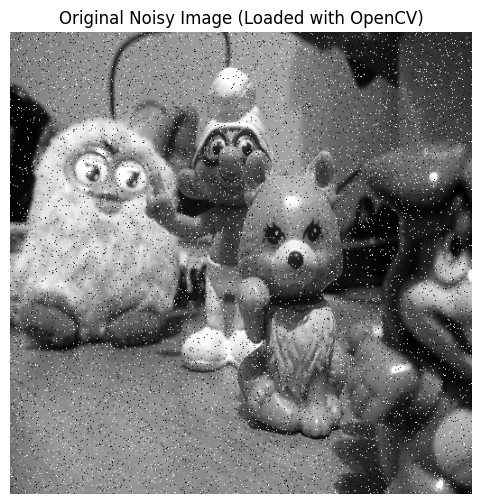

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 

def load_image(image_path):
    """Loads an image using OpenCV, converts to grayscale, and normalizes to [0, 1]."""
    try:
        # Read the image in BGR format (default for OpenCV)
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            raise FileNotFoundError # Explicitly raise if imread fails
        # Convert to grayscale
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        # Normalize to [0, 1]
        img_array = np.array(img_gray, dtype=np.float32) / 255.0
        return img_array
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path} or could not be read by OpenCV.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the image with OpenCV: {e}")
        return None

# Load the noisy image
noisy_image_path = 'noise.jpg'
noisy_img = load_image(noisy_image_path)

if noisy_img is not None:
    plt.figure(figsize=(6, 6))
    plt.imshow(noisy_img, cmap='gray')
    plt.title('Original Noisy Image (Loaded with OpenCV)')
    plt.axis('off')
    plt.show()
else:
    print("Please ensure 'noise.jpg' is in the same directory as the notebook.")


## Helper Functions: Laplacian and Central Finite Difference

We need to compute the Laplacian of an image for diffusion and regularization, and optionally, image gradients using central finite differences.
- **Laplacian Operator**: $\nabla^2 u = u_{xx} + u_{yy}$. We approximate this using the 5-point stencil:
  $\nabla^2 u(i,j) \approx u(i+1,j) + u(i-1,j) + u(i,j+1) + u(i,j-1) - 4u(i,j)$.
- **Central Finite Difference**: For gradients $\nabla u = (u_x, u_y)$:
  $u_x(i,j) \approx \frac{u(i,j+1) - u(i,j-1)}{2}$
  $u_y(i,j) \approx \frac{u(i+1,j) - u(i-1,j)}{2}$

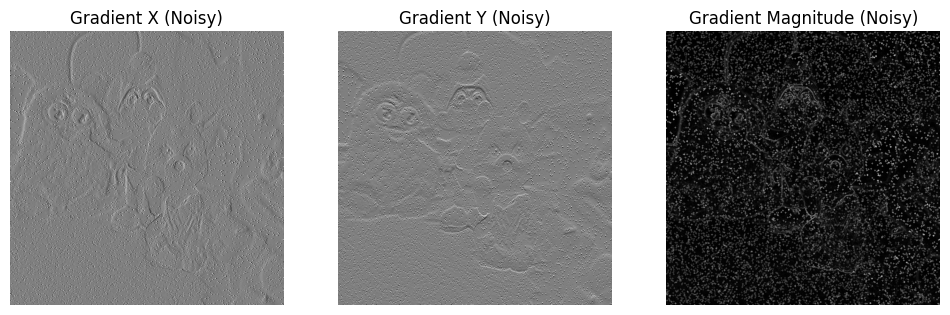

In [3]:
def laplacian_operator(image):
    """Computes the Laplacian of an image using a 5-point stencil."""
    # Pad the image to handle boundaries
    padded_image = np.pad(image, 1, mode='edge')
    
    # Compute Laplacian using array slicing
    lap = (padded_image[:-2, 1:-1] +  # Element above
           padded_image[2:, 1:-1] +   # Element below
           padded_image[1:-1, :-2] +  # Element to the left
           padded_image[1:-1, 2:] -   # Element to the right
           4 * image)                 # 4 * Current element
    return lap

def central_finite_difference(image):
    """Computes gradients in x and y directions using central differences."""
    padded_image = np.pad(image, 1, mode='edge')
    
    grad_x = (padded_image[1:-1, 2:] - padded_image[1:-1, :-2]) / 2.0
    grad_y = (padded_image[2:, 1:-1] - padded_image[:-2, 1:-1]) / 2.0
    
    return grad_x, grad_y

# Example: Compute and display gradients of the noisy image
if noisy_img is not None:
    grad_x_noisy, grad_y_noisy = central_finite_difference(noisy_img)
    grad_magnitude_noisy = np.sqrt(grad_x_noisy**2 + grad_y_noisy**2)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(grad_x_noisy, cmap='gray')
    plt.title('Gradient X (Noisy)')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(grad_y_noisy, cmap='gray')
    plt.title('Gradient Y (Noisy)')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(grad_magnitude_noisy, cmap='gray')
    plt.title('Gradient Magnitude (Noisy)')
    plt.axis('off')
    plt.show()

## Method 1: Isotropic Diffusion (Heat Equation) via Euler Method

Isotropic diffusion smooths an image by evolving it according to the heat equation:
$\frac{\partial u}{\partial t} = c \nabla^2 u$
where $u$ is the image intensity, $t$ is time, and $c$ is the diffusion coefficient.

We discretize this using the Euler method for time and finite differences for the Laplacian:
$u^{k+1}(i,j) = u^k(i,j) + \Delta t \cdot c \cdot \nabla^2 u^k(i,j)$

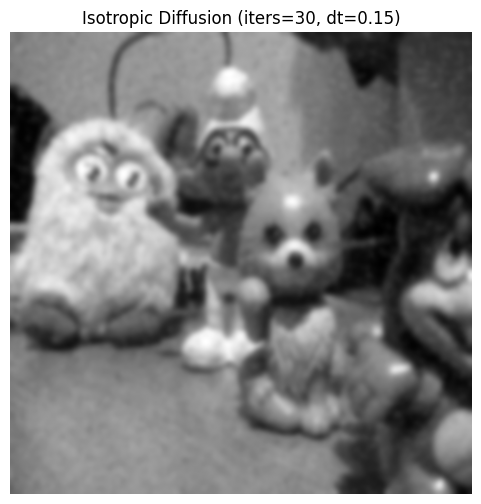

In [4]:
def isotropic_diffusion(image, iterations, dt, c=1.0):
    """
    Performs isotropic diffusion on an image.
    
    Args:
        image (np.array): The input image (normalized to [0, 1]).
        iterations (int): Number of diffusion iterations.
        dt (float): Time step for Euler method.
        c (float): Diffusion coefficient.
        
    Returns:
        np.array: The diffused image.
    """
    u = image.copy()
    for _ in range(iterations):
        lap_u = laplacian_operator(u)
        u = u + dt * c * lap_u
        u = np.clip(u, 0.0, 1.0) # Ensure pixel values stay in [0, 1]
    return u

if noisy_img is not None:
    # Parameters for isotropic diffusion
    diffusion_iterations = 30
    diffusion_dt = 0.15 # Stability often requires dt <= 0.25 for c=1 and dx=1
    diffusion_c = 1.0

    diffused_img = isotropic_diffusion(noisy_img.copy(), 
                                       iterations=diffusion_iterations, 
                                       dt=diffusion_dt, 
                                       c=diffusion_c)

    plt.figure(figsize=(6, 6))
    plt.imshow(diffused_img, cmap='gray')
    plt.title(f'Isotropic Diffusion (iters={diffusion_iterations}, dt={diffusion_dt})')
    plt.axis('off')
    plt.show()

## Method 2: Gradient Descent for Tikhonov Regularization

Tikhonov regularization for image denoising aims to find an image $u$ that is close to the noisy image $f$ while also being smooth. The energy function is:
$E(u) = \frac{1}{2} \|u - f\|_F^2 + \frac{\lambda}{2} \|\nabla u\|_F^2$
where $\|\cdot\|_F^2$ is the squared Frobenius norm, and $\lambda$ is the regularization parameter. The term $\|\nabla u\|_F^2$ can be approximated using the Laplacian: $\|\nabla u\|_F^2 \approx -u^T L u$, where $L$ is the discrete Laplacian operator.

The gradient of this energy function with respect to $u$ is:
$\nabla_u E = (u - f) - \lambda \cdot \text{Laplacian}(u)$
(Note: The sign of the Laplacian term depends on its definition. If $L$ is defined such that $Lu \approx \nabla^2 u$, then the gradient of $\frac{1}{2}\|\nabla u\|^2$ is often written as $-L u$ or $L^T L u$ depending on the precise formulation of $\nabla$ and $L$. Here, we use the form that leads to smoothing.)

We use gradient descent to minimize $E(u)$:
$u^{k+1} = u^k - \alpha \cdot \nabla_u E(u^k)$
$u^{k+1} = u^k - \alpha \cdot ( (u^k - f) - \lambda \cdot \text{Laplacian}(u^k) )$
where $\alpha$ is the step size (learning rate).

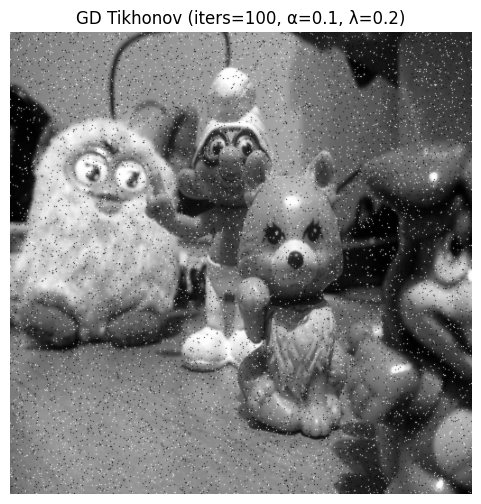

In [5]:
def gradient_descent_tikhonov(noisy_image, iterations, step_size, lambda_reg):
    """
    Performs image denoising using gradient descent for Tikhonov regularization.
    
    Args:
        noisy_image (np.array): The input noisy image (normalized to [0, 1]).
        iterations (int): Number of gradient descent iterations.
        step_size (float): Learning rate for gradient descent.
        lambda_reg (float): Regularization parameter.
        
    Returns:
        np.array: The denoised image.
    """
    u = noisy_image.copy()
    f = noisy_image.copy()
    
    for i in range(iterations):
        lap_u = laplacian_operator(u)
        grad_E = (u - f) - lambda_reg * lap_u # Gradient of the energy function
        u = u - step_size * grad_E
        u = np.clip(u, 0.0, 1.0) # Ensure pixel values stay in [0, 1]
        
        if (i + 1) % (iterations // 10) == 0 or i == 0 : # Print progress
            energy_data = 0.5 * np.sum((u - f)**2)
            energy_reg = 0.5 * lambda_reg * np.sum(lap_u * u) # Approximation of ||∇u||^2
            # A more common ||∇u||^2 is sum of squared differences.
            # For simplicity, we use the gradient as derived.
            # print(f"Iteration {i+1}/{iterations}, Energy_data: {energy_data:.2f}, Approx_Energy_reg: {energy_reg:.2f}")
            pass

    return u

if noisy_img is not None:
    # Parameters for Gradient Descent Tikhonov
    gd_iterations = 100
    gd_step_size = 0.1 
    gd_lambda_reg = 0.2 

    gd_denoised_img = gradient_descent_tikhonov(noisy_img.copy(),
                                                iterations=gd_iterations,
                                                step_size=gd_step_size,
                                                lambda_reg=gd_lambda_reg)

    plt.figure(figsize=(6,6))
    plt.imshow(gd_denoised_img, cmap='gray')
    plt.title(f'GD Tikhonov (iters={gd_iterations}, α={gd_step_size}, λ={gd_lambda_reg})')
    plt.axis('off')
    plt.show()

## Comparison of Results

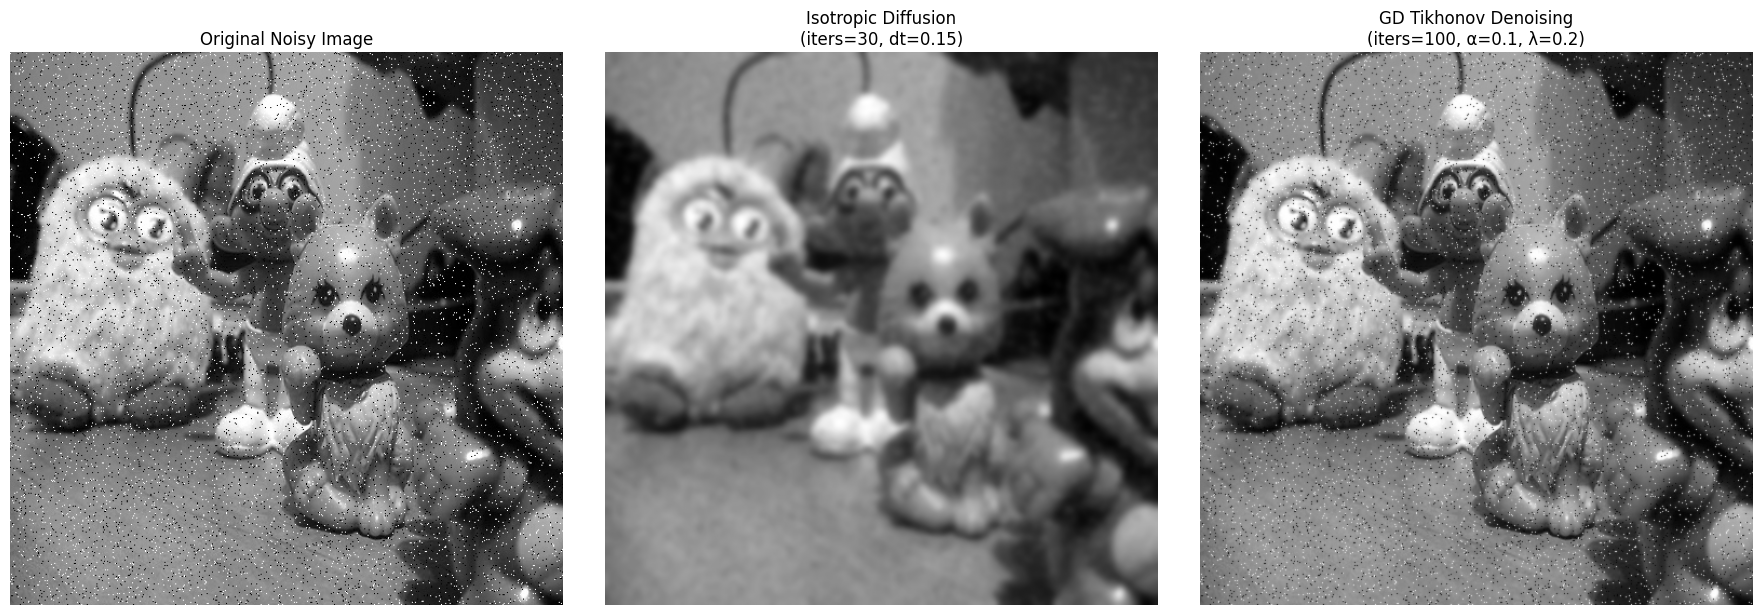

In [6]:
if noisy_img is not None:
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_img, cmap='gray')
    plt.title('Original Noisy Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(diffused_img, cmap='gray')
    plt.title(f'Isotropic Diffusion\n(iters={diffusion_iterations}, dt={diffusion_dt})')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(gd_denoised_img, cmap='gray')
    plt.title(f'GD Tikhonov Denoising\n(iters={gd_iterations}, α={gd_step_size}, λ={gd_lambda_reg})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Cannot display comparison as the original image was not loaded.")
